# Matching Pau's Fit Resault

In [1]:
import matplotlib.pylab as plt
import scipy.optimize as sop
import tables as tb
import pandas as pd
from Histogram import Histogram as hist
from PDF import PDF
import numpy as np
from Fits import Fit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 16, 12
plt.rcParams["font.size"]               = 15
#plt.rcParams["figure.max_open_warning"] = 100

In [3]:
nbinE = 150
minE, maxE = 0.600, 3.00
nbinZ = 100
minZ, maxZ = 10, 550

isotopes = ['K', 'Co', 'Bi', 'Tl']
regions = ['Anode', 'Barrel', 'Cathode']
Cathode = [b'CARRIER_PLATE',
           b'ENCLOSURE_BODY',
           b'ENCLOSURE_WINDOW',
           b'PMT_BASE',
           b'OPTICAL_PAD',
           b'PMT_BODY',
           b'CATHODE']
Anode   = [b'DB_PLUG',
           b'DICE_BOARD',
           b'ANODE_QUARTZ',
           b'EXTRA_VESSEL',
           b'SUPPORT_PLATE']
Barrel  = [b'DRIFT_TUBE',
           b'SHIELDING_STRUCT',
           b'VESSEL',
           b'ICS',
           b'PEDESTAL',
           b'HDPE_TUBE',
           b'SHIELDING_STEEL',
           b'SHIELDING_LEAD',
           b'MINI_CASTLE_STEEL',
           b'MINI_CASTLE']

## MC pdf reading 

In [4]:
mc_pdfs_volume = {}
mc_pdfs = {'Anode':{}, 'Barrel':{}, 'Cathode':{}}
aux = {'Anode':[], 'Barrel':[], 'Cathode':[]}

In [5]:
with tb.open_file("../Data/Pau/FitTable_eFidSel_RunIVc_MC_smear.h5", "r") as f_pdfs:
    pdfs = pd.DataFrame.from_records(f_pdfs.root.Data.Fit.read() )
            

In [6]:
volumes = pdfs.volume.unique()

for volume in volumes:
        mc_pdfs_volume[volume]       = {}
        mc_pdfs_volume[volume]['K']  = pdfs[np.logical_and(pdfs.volume==volume, pdfs.isotope==19 )]
        mc_pdfs_volume[volume]['Co'] = pdfs[np.logical_and(pdfs.volume==volume, pdfs.isotope==27 )] 
        mc_pdfs_volume[volume]['Bi'] = pdfs[np.logical_and(pdfs.volume==volume, pdfs.isotope==83 )]
        mc_pdfs_volume[volume]['Tl'] = pdfs[np.logical_and(pdfs.volume==volume, pdfs.isotope==81 )]

aux_cathode = {'K': [], 'Co':[], 'Bi':[], 'Tl':[]}
aux_anode   = {'K': [], 'Co':[], 'Bi':[], 'Tl':[]}
aux_barrel  = {'K': [], 'Co':[], 'Bi':[], 'Tl':[]}


for volume in volumes:
    if volume in Cathode:
        for isotope in isotopes:
            aux_cathode[isotope].append(mc_pdfs_volume[volume][isotope])
    if volume in Anode:
        for isotope in isotopes:
            aux_anode  [isotope].append(mc_pdfs_volume[volume][isotope])
    if volume in Barrel:
        for isotope in isotopes:
            aux_barrel [isotope].append(mc_pdfs_volume[volume][isotope])
    

In [7]:
for isotope in isotopes:
    mc_pdfs['Cathode'][isotope] = pd.concat(aux_cathode[isotope])
    mc_pdfs['Anode'  ][isotope] = pd.concat(aux_anode  [isotope])
    mc_pdfs['Barrel' ][isotope] = pd.concat(aux_barrel [isotope])

In [8]:
def eff(z):
    z = np.array(z)
    deadtime = .9476
    a, b, c = 3.536,-0.00331,62.57
    zbias = (np.exp(a+b*z)+c)/100
    tEff = deadtime*zbias
    return tEff

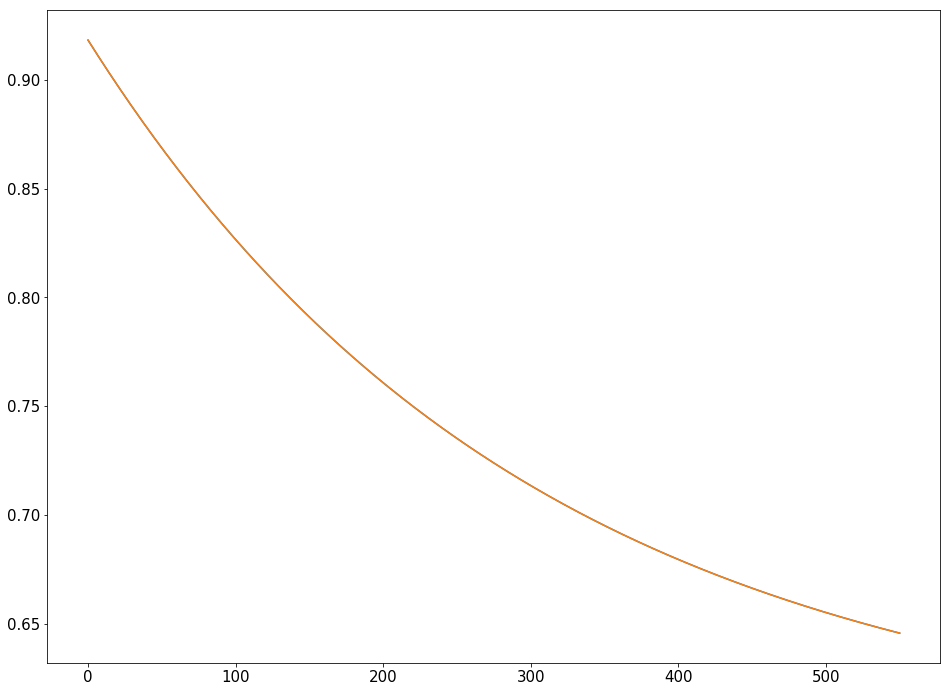

In [9]:
zavg = np.linspace(0,550,1000)
deadtime = .9476
a, b, c = 3.536,-0.00331,62.57
zbias = (np.exp(a+b*zavg)+c)/100
tEff = deadtime*zbias  #--> peso para todos los histogramas
plt.plot(zavg,  tEff)
plt.plot(zavg, eff(zavg))

In [10]:
histograms = {'E':[], 'z':[]}
name       = []
N_MC       = []

for region in regions:
        for isotope in isotopes:
            name.append(isotope+'_'+region) 
            df = mc_pdfs[region][isotope]
            
            histograms['E'].append(hist(df.energy*(1-0.019), nbinE, minE, maxE))
            histograms['z'].append(hist(df.zavg                            , nbinZ, minZ, maxZ))                      
            N_MC           .append(len(df.energy.unique()))


In [11]:
for i in range(len(histograms['z'])):
    histograms['z'][i].hist = histograms['z'][i].hist * eff(histograms['z'][i].bins)



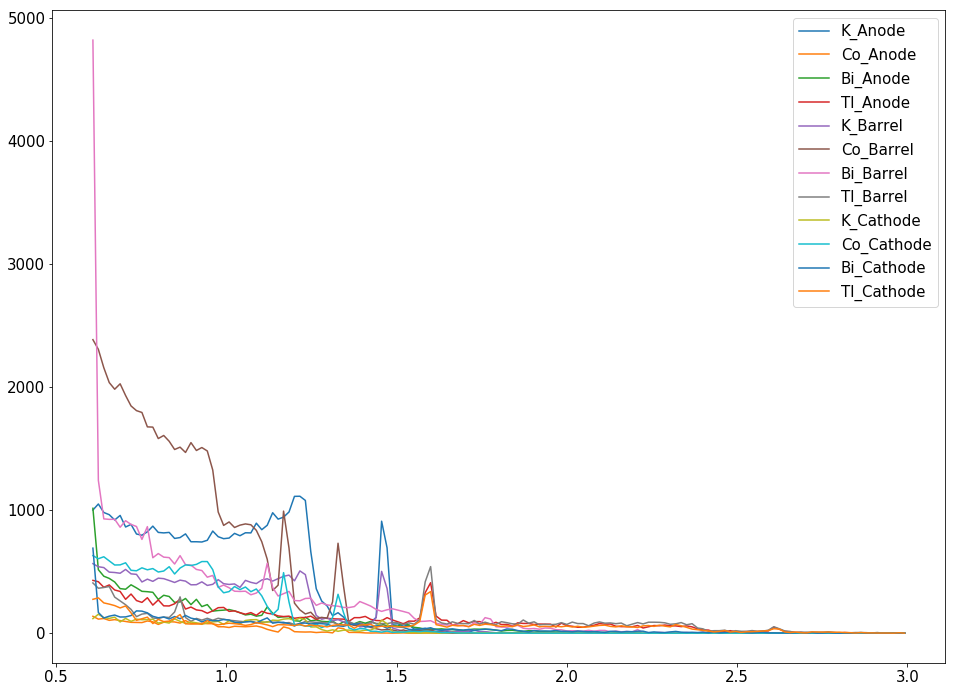

In [12]:
i = 0
for isotope in isotopes:
    for region in regions:
        h_ = histograms['E'][i]
        plt.plot(h_.bins, h_.hist, label=name[i])
        i += 1
        plt.legend()

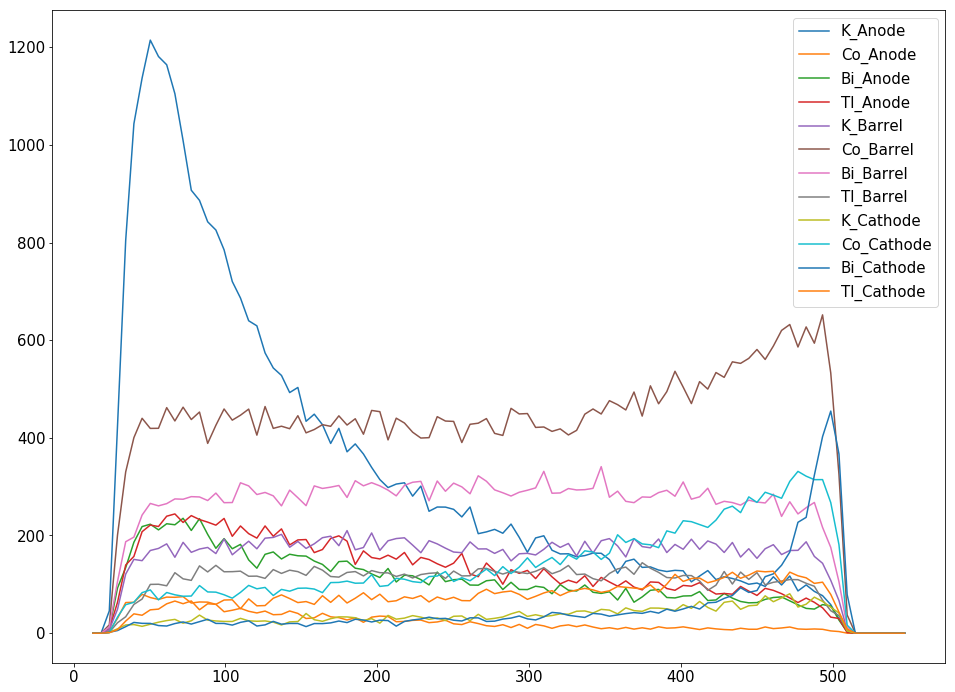

In [13]:
i = 0
for isotope in isotopes:
    for region in regions:
        h_ = histograms['z'][i]
        plt.plot(h_.bins, h_.hist, label=name[i])
        i += 1
        plt.legend()

## Data

In [14]:
with tb.open_file("../Data/Pau/FitTable_eFidSel_RunIVc_allruns.h5", "r") as f_data:
    data = pd.DataFrame.from_records(f_data.root.Data.Fit.read() )

In [15]:
m, n = 1.0341, -10.35e-3
energy = (data.energy -n)/m


h_total_e = hist(energy, nbinE, minE, maxE)
h_total_z = hist(data.zavg  , nbinZ, minZ, maxZ)

totals = {'E': h_total_e    , 'z': h_total_z   }

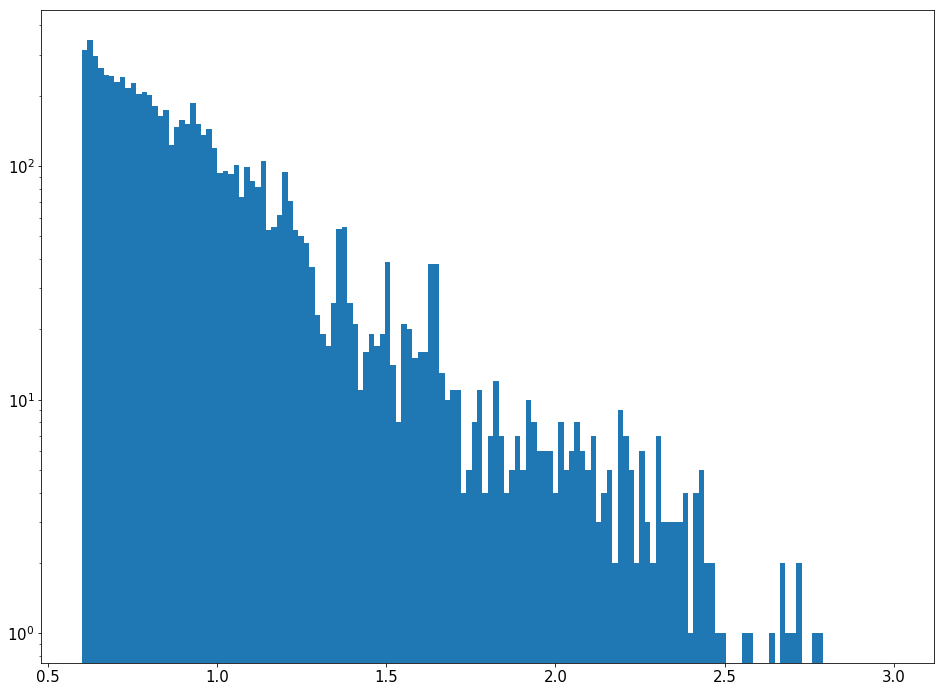

In [16]:
plt.hist(data.energy,nbinE,[minE,maxE]);
plt.yscale('log')

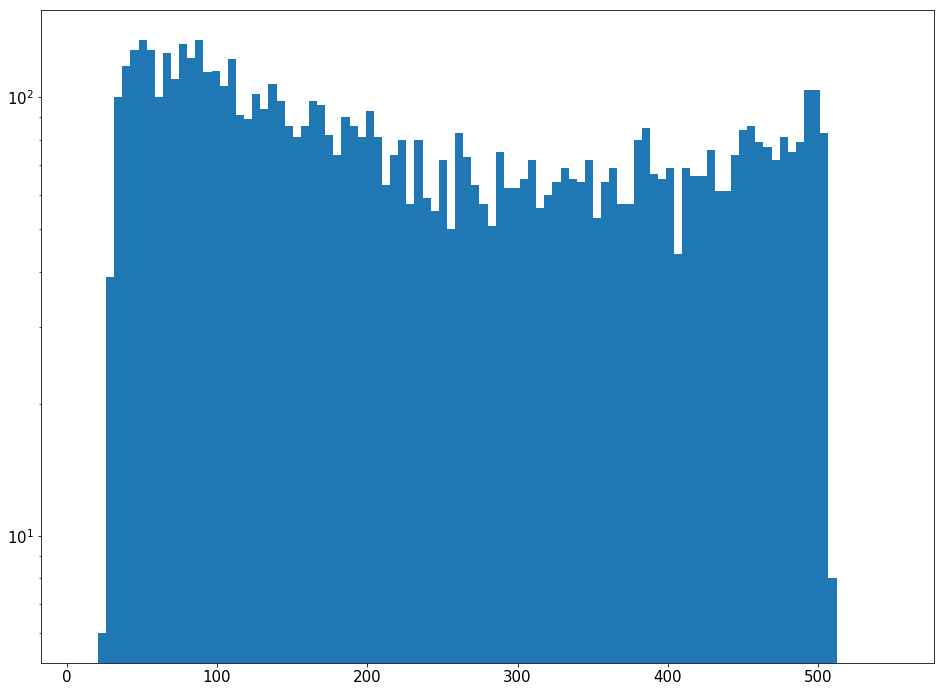

In [17]:
plt.hist(data.zavg,nbinZ,[minZ,maxZ]);
plt.yscale('log')

## Fitting

In [18]:
N_MC  = np.array(N_MC)
N_0MC = 27.167/(5.9*365.24) * N_MC

In [19]:
x_dict = {'E': histograms['E'][0].bins , 'z': histograms['z'][0].bins}

pdfs = {'E':[], 'z':[]}
interpol = 'cubic'
pdfs['E'] = [PDF(h_, interpolation=interpol) for h_ in histograms['E']]
pdfs['z'] = [PDF(h_, interpolation=interpol) for h_ in histograms['z']]


In [20]:
from iminuit import Minuit as imin

In [21]:
ratios = np.ones_like(N_0MC)
bounds = [[0.5,1.5]]*len(N_0MC)
fit = Fit(x_dict, totals, pdfs,N_0MC)


m = imin.from_array_func(fit.LLh, np.ones_like(N_0MC), 
                         name=name, 
                         limit=[[0,None]]*len(N_0MC))

min_, res_ll = m.migrad()

FCN = 1466.5809096444864 
 TOTAL NCALL = 1270 
 NCALLS = 1270 
 
 
 EDM = 1.9684961058477723e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,K_Anode,0.886087,0.205646,,,0,,No
1,Co_Anode,31.3423,4.54272,,,0,,No
2,Bi_Anode,7.69081,1.34733,,,0,,No
3,Tl_Anode,1.08024,1.20324,,,0,,No
4,K_Barrel,1.96759e-10,0.168701,,,0,,No
5,Co_Barrel,4.4401,0.236709,,,0,,No
6,Bi_Barrel,2.3153e-11,0.17835,,,0,,No
7,Tl_Barrel,2.68755,1.01219,,,0,,No
8,K_Cathode,1.28929e-09,0.553208,,,0,,No
9,Co_Cathode,2.56009e-11,0.134636,,,0,,No


In [22]:
res_ll

[{'number': 0,
  'name': 'K_Anode',
  'value': 0.8860871390673184,
  'error': 0.20564630899646608,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': False,
  'lower_limit': 0.0,
  'upper_limit': None},
 {'number': 1,
  'name': 'Co_Anode',
  'value': 31.34229862803062,
  'error': 4.542723856882914,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': False,
  'lower_limit': 0.0,
  'upper_limit': None},
 {'number': 2,
  'name': 'Bi_Anode',
  'value': 7.690806094664248,
  'error': 1.3473342204654033,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': False,
  'lower_limit': 0.0,
  'upper_limit': None},
 {'number': 3,
  'name': 'Tl_Anode',
  'value': 1.0802444777924585,
  'error': 1.2032407021615277,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': 

In [23]:
result    = np.array([res.value for res in res_ll])
error     = np.array([res.error for res in res_ll])
factors   = result * N_0MC
#factors   = np.array([514.04165853, 514.04179216, 514.04164491, 514.04166726,
#                      514.04167153, 514.0416711 , 514.04166152, 514.04166413,
#                      514.04163411, 514.04167932, 514.04171903, 514.04167595])

pdfs_plot = {'E':[], 'z':[]}

interpol = 'nearest'

pdfs_plot['E'] = [PDF(h_, factor=factors[i], interpolation=interpol) for h_, i in zip(histograms['E'], range(len(N_0MC)))]
pdfs_plot['z'] = [PDF(h_, factor=factors[i], interpolation=interpol) for h_, i in zip(histograms['z'], range(len(N_0MC)))]


In [24]:
Ep = np.linspace(totals['E'].bins[0],totals['E'].bins[-1],1000)
Zp = np.linspace(totals['z'].bins[0],totals['z'].bins[-1],1000)

y_e = [pdf.pdf(Ep) for pdf in pdfs_plot['E']] 
y_z = [pdf.pdf(Zp) for pdf in pdfs_plot['z']] 


fittotal_e = np.sum(y_e, axis=0)
fittotal_z = np.sum(y_z, axis=0)

anode_e   = y_e[0] + y_e[1] + y_e[2]  + y_e[3]
barrel_e  = y_e[4] + y_e[5] + y_e[6]  + y_e[7]
cathode_e = y_e[8] + y_e[9] + y_e[10] + y_e[11]

anode_z   = y_z[0] + y_z[1] + y_z[2]  + y_z[3]
barrel_z  = y_z[4] + y_z[5] + y_z[6]  + y_z[7]
cathode_z = y_z[8] + y_z[9] + y_z[10] + y_z[11]

K_e  = y_e[0] + y_e[4] + y_e[8] 
Co_e = y_e[1] + y_e[5] + y_e[9]
Bi_e = y_e[2] + y_e[6] + y_e[10]
Tl_e = y_e[3] + y_e[7] + y_e[11] 

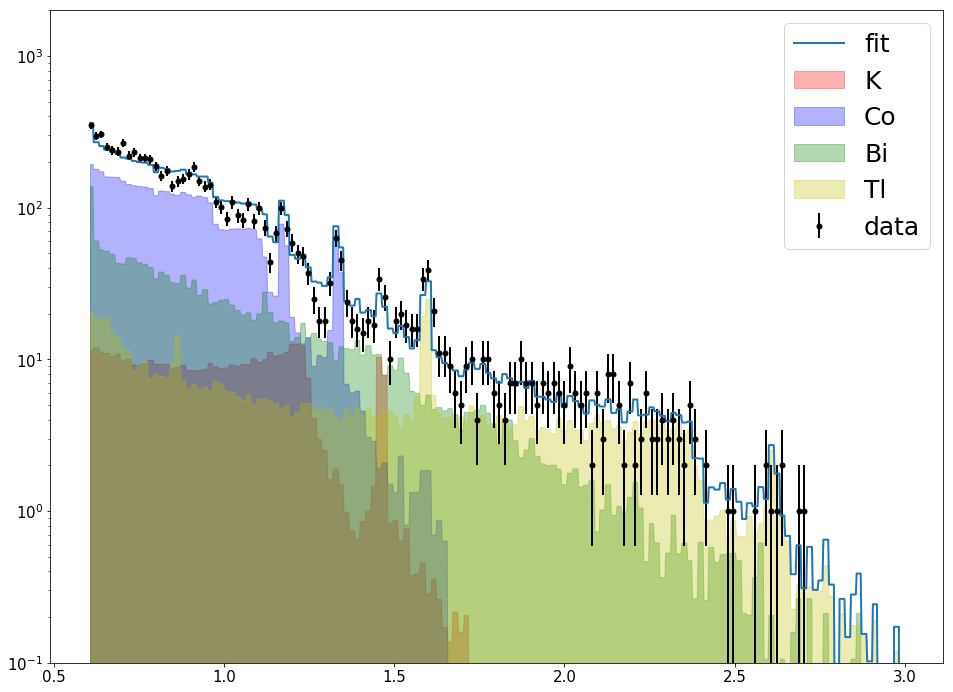

In [25]:
alfa= 0.3
plt.semilogy()
plt.ylim(1e-1,2e3)

plt.errorbar(totals['E'].bins, totals['E'].hist, yerr=np.sqrt(totals['E'].hist),
             marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')

plt.plot(Ep, fittotal_e, label='fit', linewidth=2,)


plt.fill_between(Ep, 0 , K_e  , label='K'  ,alpha=alfa,color='r')
plt.fill_between(Ep, 0 , Co_e , label='Co' ,alpha=alfa,color='b')
plt.fill_between(Ep, 0 , Bi_e , label='Bi' ,alpha=alfa,color='g')
plt.fill_between(Ep, 0 , Tl_e , label='Tl' ,alpha=alfa,color='y')


'''
plt.fill_between(Ep, 0 , fit_0_a_e, label='fit_e_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , fit_1_a_e, label='fit_e_1',alpha=alfa,color='b')
plt.fill_between(Ep, 0 , fit_2_a_e, label='fit_e_2',alpha=alfa,color='g')

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')
'''
plt.legend().get_frame().set_facecolor('0.95')
plt.legend(fontsize=25)

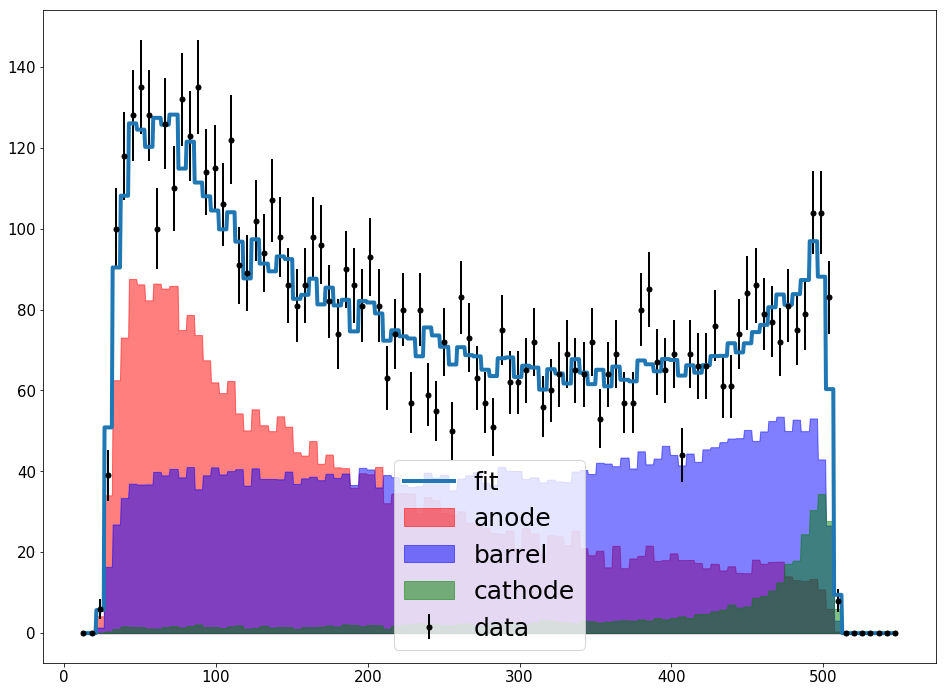

In [26]:
alfa= 0.5


plt.errorbar(totals['z'].bins, totals['z'].hist, yerr=np.sqrt(totals['z'].hist),
             marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z, label='fit', linewidth=4,)

plt.fill_between(Zp, 0 , anode_z  , label='anode'  ,alpha=alfa,color='r')
plt.fill_between(Zp, 0 , barrel_z , label='barrel' ,alpha=alfa,color='b')
plt.fill_between(Zp, 0 , cathode_z, label='cathode',alpha=alfa,color='g')


'''

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')
'''
plt.legend(fontsize=25)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 8 Text yticklabel objects>)

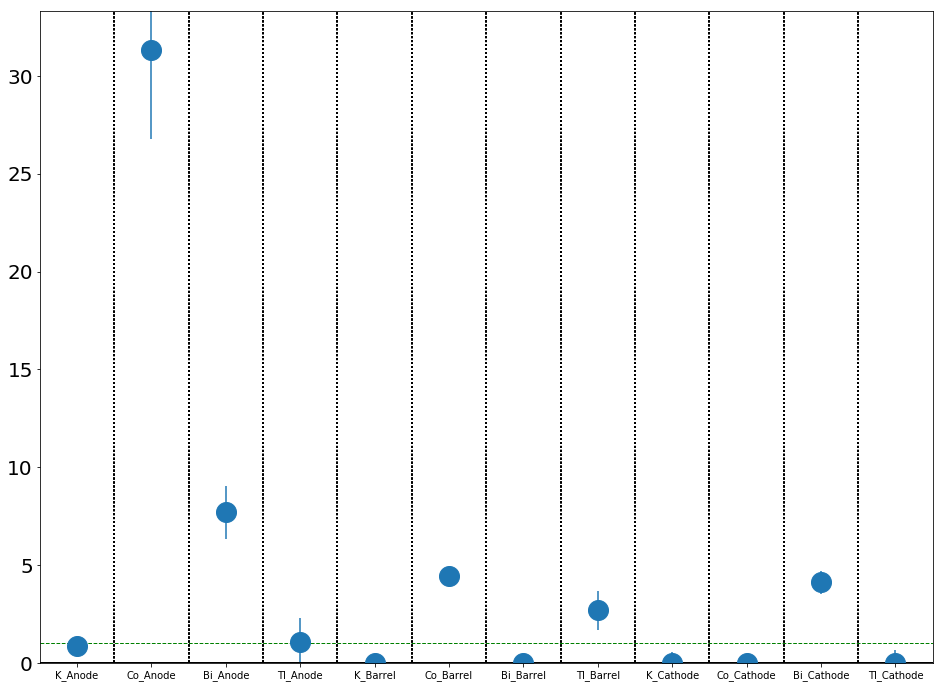

In [27]:
plt.errorbar(range((len(result))), result, error, fmt='.', markersize=40)
plt.hlines(1, -1, 13, linewidth=1, linestyles='dashed', color='g')
plt.hlines(0, -1, 13, linewidth=3)
for i in range(len(result)-1):
    plt.vlines(np.arange((len(result)-1))+.5, -1, 100,linestyles='dotted')
plt.xlim(-.5,11.5)
plt.ylim(0.0001, np.max(result)+2)
plt.xticks(range((len(result))),name, fontsize=10);
plt.yticks(fontsize=20)
#plt.yscale('log')

In [28]:
m.print_matrix()

+,K_Anode,Co_Anode,Bi_Anode,Tl_Anode,K_Barrel,Co_Barrel,Bi_Barrel,Tl_Barrel,K_Cathode,Co_Cathode,Bi_Cathode,Tl_Cathode
K_Anode,1.00,-0.32,-0.27,-0.19,0.00,0.17,-0.00,0.22,0.00,-0.00,-0.07,-0.00
Co_Anode,-0.32,1.00,-0.24,-0.22,-0.00,-0.55,0.00,0.27,-0.00,0.00,0.41,0.00
Bi_Anode,-0.27,-0.24,1.00,-0.49,0.00,-0.46,-0.00,0.33,0.00,-0.00,-0.11,0.00
Tl_Anode,-0.19,-0.22,-0.49,1.00,-0.00,0.44,-0.00,-0.95,-0.00,-0.00,-0.06,-0.00
K_Barrel,0.00,-0.00,0.00,-0.00,1.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
Co_Barrel,0.17,-0.55,-0.46,0.44,0.00,1.00,-0.00,-0.39,0.00,-0.00,-0.44,-0.00
Bi_Barrel,-0.00,0.00,-0.00,-0.00,0.00,-0.00,1.00,-0.00,0.00,-0.00,-0.00,0.00
Tl_Barrel,0.22,0.27,0.33,-0.95,-0.00,-0.39,-0.00,1.00,0.00,-0.00,-0.00,-0.00
K_Cathode,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
Co_Cathode,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,1.00,-0.00,0.00
